# ML Zoomcamp Homework Week 02

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Dataset

In [57]:
# ! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [58]:
df = pd.read_csv('laptops.csv')

In [59]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [60]:
filtered_df = df[['ram', 'storage', 'screen', 'final_price']].copy()

## EDA

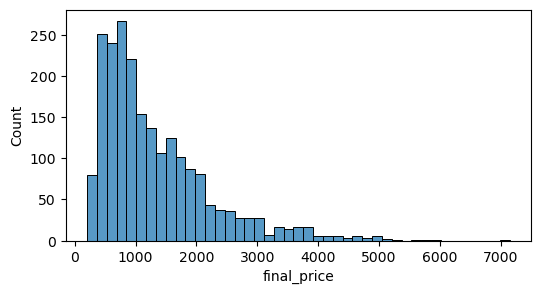

In [61]:
plt.figure(figsize=(6, 3), frameon=True)
sns.histplot(filtered_df['final_price'])
plt.show()

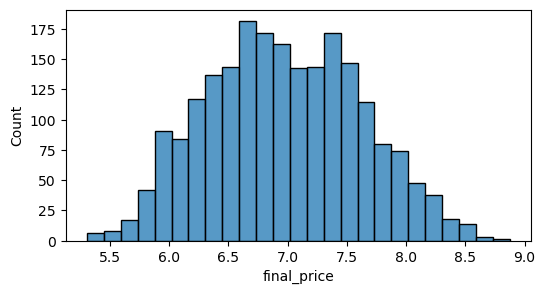

In [62]:
plt.figure(figsize=(6, 3), frameon=True)
sns.histplot(np.log1p(filtered_df['final_price']))
plt.show()

It's evident that we need to normalise the response witha log transformation but this is not part of the instructions.

In [63]:
[col for col in filtered_df if filtered_df[col].isnull().any()]

['screen']

### Answer 1

The `screen` column has missing values

## Question 2

In [64]:
print(filtered_df['ram'].describe())

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64


### Answer 2

The median for the `ram` column is `16`

In [65]:
n = len(filtered_df)
n_test = int(0.2 * n)
n_val = int(0.2 * n)
n_train = n - n_test - n_val


In [66]:
idx = np.arange(n)

In [67]:
np.random.seed(42)
np.random.shuffle(idx)

In [68]:
df_train = filtered_df.iloc[idx[:n_train]]
df_val = filtered_df.iloc[idx[n_train:n_train+n_val]]
df_test = filtered_df.iloc[idx[n_train+n_val:]]

In [69]:
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [70]:
y_test = df_test['final_price'].values
y_val = df_val['final_price'].values
y_train = df_train['final_price'].values

In [71]:
df_test = df_test.drop('final_price', axis=1)
df_val = df_val.drop('final_price', axis=1)
df_train = df_train.drop('final_price', axis=1)

## Question 3

In [72]:
df_train_zero = df_train.copy()
df_train_zero['screen'] = df_train_zero['screen'].fillna(0)

df_train_median = df_train.copy()
df_train_median['screen'] = df_train_median['screen'].fillna(df_train_median['screen'].median())

In [73]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [74]:
def calc_rmse(y_actual, y_pred):
    squared_error = (y_actual - y_pred) ** 2
    mean_squared_error = squared_error.mean()
    return np.sqrt(mean_squared_error)

In [75]:
parameters_zero = train_linear_regression(df_train_zero, y_train)

In [76]:
y_pred_zero = parameters_zero[0] + df_train_zero.to_numpy().dot(parameters_zero[1])

In [77]:
round(calc_rmse(y_train, y_pred_zero), 2)

np.float64(602.39)

In [78]:
parameters_median = train_linear_regression(df_train_median, y_train)

In [79]:
y_pred_median = parameters_median[0] + df_train_median.to_numpy().dot(parameters_median[1])

In [80]:
round(calc_rmse(y_train, y_pred_median), 2)

np.float64(602.2)

### Answer 3

Both options for data imputation are equally good at this point

## Question 4

In [81]:
X = df_train_zero.values

In [82]:
def train_lr_regularized(X, y, r_param):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r_param * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [83]:
r_params = [0, 0.01, 0.1, 1, 5, 10, 100]

for r_param in r_params:
    print(r_param)
    model_parameters = train_lr_regularized(X, y_train, r_param)
    # print(model_parameters)
    y_pred = model_parameters[0] + df_val.fillna(0).values.dot(model_parameters[1])
    rmse = calc_rmse(y_val, y_pred)
    print(round(rmse, 2))
    

0
597.36
0.01
597.36
0.1
597.35
1
597.21
5
597.01
10
597.06
100
597.9


### Answer 4

`r = 0` 

## Question 5

In [53]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmses = []

for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = filtered_df.iloc[idx[:n_train]]
    df_val = filtered_df.iloc[idx[n_train:n_train+n_val]]
    df_test = filtered_df.iloc[idx[n_train+n_val:]]

    y_test = df_test['final_price'].values
    y_val = df_val['final_price'].values
    y_train = df_train['final_price'].values
    
    df_test = df_test.drop('final_price', axis=1)
    df_val = df_val.drop('final_price', axis=1)
    df_train = df_train.drop('final_price', axis=1)

    X_train = df_train.fillna(0).values
    
    parameters = train_linear_regression(X_train, y_train)
    # print(parameters)
    y_pred = parameters[0] + df_val.fillna(0).values.dot(parameters[1])

    rmse = calc_rmse(y_val, y_pred)
    print(rmse)
    rmses.append(rmse)

rmse_std = round(np.std(rmses, axis=0), 3)

print(rmse_std)

565.4520868771027
636.7985423056726
588.9558697907962
597.8148920012521
571.962791511102
573.2383256618949
647.3438328407208
550.4398184485952
587.333503616991
576.1017929433108
29.176


## Question 6

In [54]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = filtered_df.iloc[idx[:n_train]]
df_val = filtered_df.iloc[idx[n_train:n_train+n_val]]
df_test = filtered_df.iloc[idx[n_train+n_val:]]

df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

y_test = df_test['final_price'].values
y_val = df_val['final_price'].values
y_train = df_train['final_price'].values

df_test = df_test.drop('final_price', axis=1)
df_val = df_val.drop('final_price', axis=1)
df_train = df_train.drop('final_price', axis=1)

df_train = pd.concat([df_train, df_val])
y_train = np.concatenate([y_train, y_val])

X_train = df_train.fillna(0).values

parameters = train_lr_regularized(X_train, y_train, r_param=0.001)
# print(parameters)
y_pred = parameters[0] + df_test.fillna(0).values.dot(parameters[1])

rmse = calc_rmse(y_test, y_pred)
print(rmse)

608.609982204956
